_Lambda School Data Science — Regression 2_ 

This sprint, your project is Caterpillar Tube Pricing: Predict the prices suppliers will quote for industrial tube assemblies.

# Log-Linear Regression, Feature Engineering


#### Objectives
- log-transform regression target with right-skewed distribution
- use regression metric: RMSLE
- do feature engineering with relational data

## Process

#### Francois Chollet, [Deep Learning with Python](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/README.md), Chapter 4: Fundamentals of machine learning, "A universal workflow of machine learning"
 
> **1. Define the problem at hand and the data on which you’ll train.** Collect this data, or annotate it with labels if need be.

> **2. Choose how you’ll measure success on your problem.** Which metrics will you monitor on your validation data?

> **3. Determine your evaluation protocol:** hold-out validation? K-fold validation? Which portion of the data should you use for validation?

> **4. Develop a first model that does better than a basic baseline:** a model with statistical power.

> **5. Develop a model that overfits.** The universal tension in machine learning is between optimization and generalization; the ideal model is one that stands right at the border between underfitting and overfitting; between undercapacity and overcapacity. To figure out where this border lies, first you must cross it.

> **6. Regularize your model and tune its hyperparameters, based on performance on the validation data.** Repeatedly modify your model, train it, evaluate on your validation data (not the test data, at this point), modify it again, and repeat, until the model is as good as it can get. 

> **Iterate on feature engineering: add new features, or remove features that don’t seem to be informative.** Once you’ve developed a satisfactory model configuration, you can train your final production model on all the available data (training and validation) and evaluate it one last time on the test set.


## Moore's Law dataset

#### Background
- https://en.wikipedia.org/wiki/Moore%27s_law
- https://en.wikipedia.org/wiki/Transistor_count

#### Scrape HTML tables with Pandas!
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_html.html
- https://medium.com/@ageitgey/quick-tip-the-easiest-way-to-grab-data-out-of-a-web-page-in-python-7153cecfca58

#### More web scraping options
- https://automatetheboringstuff.com/chapter11/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
len(tables)

17

In [4]:
tables[0]

,Processor,Transistor count,Date of introduction,Designer,Process,Area
0,Intel 4004,2300,1971,Intel,"10,000 nm",12 mm²
1,Intel 8008,3500,1972,Intel,"10,000 nm",14 mm²
2,NEC μCOM-4,"2,500[6][7]",1973,NEC,"7,500 nm[8]",?
3,Toshiba TLCS-12,"2,500[9]",1973,Toshiba,"6,000 nm",32 mm²
4,Motorola 6800,4100,1974,Motorola,"6,000 nm",16 mm²
5,Intel 8080,4500,1974,Intel,"6,000 nm",20 mm²
6,TMS 1000,8000,1974[10],Texas Instruments,"8,000 nm",11 mm²
7,MOS Technology 6502,"4,528[a][11]",1975,MOS Technology,"8,000 nm",21 mm²
8,RCA 1802,5000,1976,RCA,"5,000 nm",27 mm²
9,Zilog Z80,"8,500[b]",1976,Zilog,"4,000 nm",18 mm²


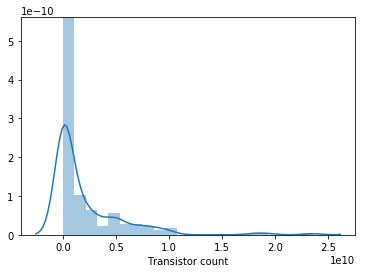

In [2]:
# Scrape data
tables = pd.read_html('https://en.wikipedia.org/wiki/Transistor_count', header=0)
moore = tables[0]
moore = moore[['Date of introduction', 'Transistor count']].dropna()

# Clean data
for column in moore:
    moore[column] = (moore[column]
                     .str.split('[').str[0]  # Remove citations
                     .str.replace(r'\D','')  # Remove non-digit characters
                     .astype(int))
    
moore = moore.sort_values(by='Date of introduction')

# Plot distribution of transistor counts
sns.distplot(moore['Transistor count']);

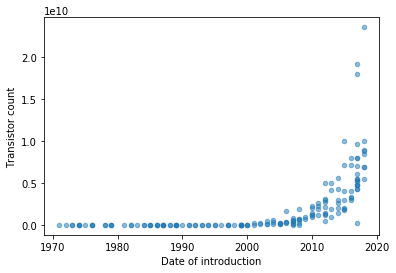

In [7]:
# Plot relationship between date & transistors
moore.plot(x='Date of introduction', y='Transistor count', kind='scatter', alpha=0.5);

In [8]:
# Log-transform the target
moore['log(Transistor count)'] = np.log(moore['Transistor count'])

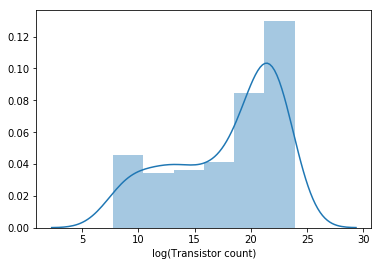

In [9]:
# Plot distribution of log-transformed target
sns.distplot(moore['log(Transistor count)']);

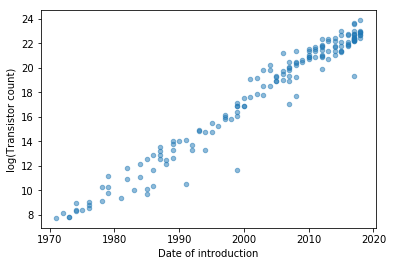

In [10]:
# Plot relationship between date & log-transformed target
moore.plot(x='Date of introduction', y='log(Transistor count)', kind='scatter', alpha=0.5);

#### Terence Parr & Jeremy Howard, [The Mechanics of Machine Learning, Chapter 5.5](https://mlbook.explained.ai/prep.html#logtarget)

> Transforming the target variable (using the mathematical log function) into a tighter, more uniform space makes life easier for any model.

> The only problem is that, while easy to execute, understanding why taking the log of the target variable works and how it affects the training/testing process is intellectually challenging. You can skip this section for now, if you like, but just remember that this technique exists and check back here if needed in the future.

> Optimally, the distribution of prices would be a narrow “bell curve” distribution without a tail. This would make predictions based upon average prices more accurate. We need a mathematical operation that transforms the widely-distributed target prices into a new space. The “price in dollars space” has a long right tail because of outliers and we want to squeeze that space into a new space that is normally distributed (“bell curved”). More specifically, we need to shrink large values a lot and smaller values a little. That magic operation is called the logarithm or log for short. 

> To make actual predictions, we have to take the exp of model predictions to get prices in dollars instead of log dollars.

#### Wikipedia, [Logarithm](https://en.wikipedia.org/wiki/Logarithm)

> Addition, multiplication, and exponentiation are three fundamental arithmetic operations. Addition can be undone by subtraction. Multiplication can be undone by division. The idea and purpose of **logarithms** is also to **undo** a fundamental arithmetic operation, namely raising a number to a certain power, an operation also known as **exponentiation.** 

> For example, raising 2 to the third power yields 8.

> The logarithm (with respect to base 2) of 8 is 3, reflecting the fact that 2 was raised to the third power to get 8.

### Use Numpy for exponents and logarithms functions
- https://docs.scipy.org/doc/numpy/reference/routines.math.html#exponents-and-logarithms

In [11]:
2 ** 3

8

In [12]:
np.log2(8)

3.0

In [13]:
np.e ** 42

1.7392749415204972e+18

In [14]:
np.log(1.7392749415204972e+18)

42.0

In [15]:
np.e

2.718281828459045

In [16]:
np.log(0)

/home/akim/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


-inf

In [18]:
np.log(1)

0.0

In [17]:
np.log1p(0)

0.0

In [19]:
np.log1p(42)

3.7612001156935624

In [20]:
np.log(42 + 1)

3.7612001156935624

In [21]:
np.expm1(3.7612001156935624)

42.0

In [22]:
np.exp(3.7612001156935624) - 1

42.0

In [23]:
# Fit Linear Regression with log-transformed target
from sklearn.linear_model import LinearRegression
model = LinearRegression()
X = moore[['Date of introduction']]
y_log = moore['log(Transistor count)']

In [24]:
model.fit(X, y_log)
y_pred_log = model.predict(X)

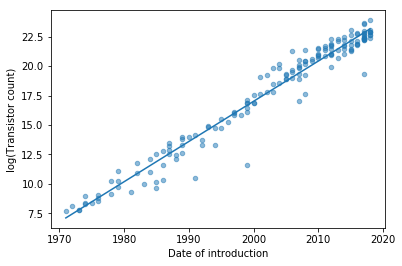

In [25]:
# Plot line of best fit, in units of log-transistors
ax = moore.plot(x='Date of introduction', y='log(Transistor count)', kind='scatter', alpha=0.5)
ax.plot(X, y_pred_log);

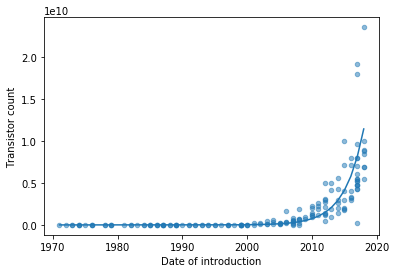

In [26]:
# Convert log-transistors to transistors
y_pred = np.expm1(y_pred_log)

# Plot line of best fit, in units of transistors
ax = moore.plot(x='Date of introduction', y='Transistor count', kind='scatter', alpha=0.5)
ax.plot(X, y_pred);

## Caterpillar dataset

## Define the problem 🚜

#### [Description](https://www.kaggle.com/c/caterpillar-tube-pricing/overview/description)

> Like snowflakes, it's difficult to find two tubes in Caterpillar's diverse catalogue of machinery that are exactly alike. Tubes can vary across a number of dimensions, including base materials, number of bends, bend radius, bolt patterns, and end types.

> Currently, Caterpillar relies on a variety of suppliers to manufacture these tube assemblies, each having their own unique pricing model. This competition provides detailed tube, component, and annual volume datasets, and challenges you to predict the price a supplier will quote for a given tube assembly. 




## Define the data on which you'll train

#### [Data Description](https://www.kaggle.com/c/caterpillar-tube-pricing/data)

> The dataset is comprised of a large number of relational tables that describe the physical properties of tube assemblies. You are challenged to combine the characteristics of each tube assembly with supplier pricing dynamics in order to forecast a quote price for each tube. The quote price is labeled as cost in the data.


## Get data


### Option 1. Kaggle web UI
 
Sign in to Kaggle and go to the [Caterpillar Tube Pricing](https://www.kaggle.com/c/caterpillar-tube-pricing) competition. Go to the Data page. After you have accepted the rules of the competition, use the download buttons to download the data.


### Option 2. Kaggle API

1. [Follow these instructions](https://github.com/Kaggle/kaggle-api#api-credentials) to create a Kaggle “API Token” and download your `kaggle.json` file.

2. Put `kaggle.json` in the correct location.

  - If you're using Anaconda, put the file in the directory specified in the [instructions](https://github.com/Kaggle/kaggle-api#api-credentials).

  - If you're using Google Colab, upload the file to your Google Drive, and run this cell:

  ```
  from google.colab import drive
  drive.mount('/content/drive')
  %env KAGGLE_CONFIG_DIR=/content/drive/My Drive/
  ```

3. Install the Kaggle API package.
```
pip install kaggle
```

4. After you have accepted the rules of the competiton, use the Kaggle API package to get the data.
```
kaggle competitions download -c caterpillar-tube-pricing
```

### Option 3. GitHub Repo

Get the zip file from the [GitHub repo](https://github.com/LambdaSchool/DS-Unit-2-Applied-Modeling/tree/master/data/caterpillar), by cloning locally, or downloading directly from the web.

In [27]:
!wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/caterpillar/caterpillar-tube-pricing.zip

--2019-08-06 22:40:49--  https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/caterpillar/caterpillar-tube-pricing.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.20.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.20.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 823789 (804K) [application/zip]
Saving to: ‘caterpillar-tube-pricing.zip.3’

caterpillar-tube-pr 100%[===================>] 804.48K  4.94MB/s    in 0.2s    

2019-08-06 22:40:49 (4.94 MB/s) - ‘caterpillar-tube-pricing.zip.3’ saved [823789/823789]



In [28]:
!ls *.zip

caterpillar-tube-pricing.zip  data.zip


In [29]:
!unzip -o caterpillar-tube-pricing.zip

Archive:  caterpillar-tube-pricing.zip
  inflating: sample_submission.csv   
  inflating: data.zip                


In [30]:
!unzip -o data.zip

Archive:  data.zip
  inflating: competition_data/bill_of_materials.csv  
  inflating: competition_data/comp_adaptor.csv  
  inflating: competition_data/comp_boss.csv  
  inflating: competition_data/comp_elbow.csv  
  inflating: competition_data/comp_float.csv  
  inflating: competition_data/comp_hfl.csv  
  inflating: competition_data/comp_nut.csv  
  inflating: competition_data/comp_other.csv  
  inflating: competition_data/comp_sleeve.csv  
  inflating: competition_data/comp_straight.csv  
  inflating: competition_data/comp_tee.csv  
  inflating: competition_data/comp_threaded.csv  
  inflating: competition_data/components.csv  
  inflating: competition_data/specs.csv  
  inflating: competition_data/test_set.csv  
  inflating: competition_data/train_set.csv  
  inflating: competition_data/tube.csv  
  inflating: competition_data/tube_end_form.csv  
  inflating: competition_data/type_component.csv  
  inflating: competition_data/type_connection.csv  
  inflating: competition_data/type

#### Get filenames & shapes

[Python Standard Library: glob](https://docs.python.org/3/library/glob.html)

> The `glob` module finds all the pathnames matching a specified pattern

In [31]:
from glob import glob

In [35]:
import pandas as pd

for path in glob('competition_data/*.csv'):
    df = pd.read_csv(path)
    print(path, df.shape)

competition_data/comp_adaptor.csv (25, 20)
competition_data/bill_of_materials.csv (21198, 17)
competition_data/tube.csv (21198, 16)
competition_data/test_set.csv (30235, 8)
competition_data/type_component.csv (29, 2)
competition_data/components.csv (2048, 3)
competition_data/comp_elbow.csv (178, 16)
competition_data/comp_other.csv (1001, 3)
competition_data/comp_hfl.csv (6, 9)
competition_data/type_connection.csv (14, 2)
competition_data/specs.csv (21198, 11)
competition_data/comp_sleeve.csv (50, 10)
competition_data/type_end_form.csv (8, 2)
competition_data/comp_nut.csv (65, 11)
competition_data/comp_float.csv (16, 7)
competition_data/comp_threaded.csv (194, 32)
competition_data/tube_end_form.csv (27, 2)
competition_data/comp_tee.csv (4, 14)
competition_data/train_set.csv (30213, 8)
competition_data/comp_straight.csv (361, 12)
competition_data/comp_boss.csv (147, 15)



##  Choose how you'll measure success on your problem

> Which metrics will you monitor on your validation data?

#### [Evaluation](https://www.kaggle.com/c/caterpillar-tube-pricing/overview/evaluation)

> Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE). The RMSLE is calculated as
>
> $\sqrt{\frac{1}{n} \sum_{i=1}^{n}\left(\log \left(p_{i}+1\right)-\log \left(a_{i}+1\right)\right)^{2}}$
>
> Where:
>
> - $n$ is the number of price quotes in the test set
> - $p_i$ is your predicted price
> - $a_i$ is the actual price
> - $log(x)$ is the natural logarithm

#### [Scikit-Learn User Guide](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-log-error)

> The `mean_squared_log_error` function is best to use when targets have exponential growth, such as population counts, average sales of a commodity over a span of years etc. Note that this metric penalizes an under-predicted estimate greater than an over-predicted estimate.

In [36]:
import numpy as np
from sklearn.metrics import mean_squared_log_error

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

## Determine your evaluation protocol

> Which portion of the data should you use for validation?

#### Rachel Thomas, [How (and why) to create a good validation set](https://www.fast.ai/2017/11/13/validation-sets/)

> You will want to create your own training and validation sets (by splitting the Kaggle “training” data). You will just use your smaller training set (a subset of Kaggle’s training data) for building your model, and you can evaluate it on your validation set (also a subset of Kaggle’s training data) before you submit to Kaggle.

> When is a random subset not good enough?
> - Time series
> - New people, new boats, new…

#### Does the test set have different dates?

In [37]:
trainval = pd.read_csv('competition_data/train_set.csv')
test = pd.read_csv('competition_data/test_set.csv')

In [40]:
trainval.head(10)

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561
5,TA-00002,S-0066,2013-07-07,0,0,Yes,50,3.224406
6,TA-00002,S-0066,2013-07-07,0,0,Yes,100,3.082521
7,TA-00002,S-0066,2013-07-07,0,0,Yes,250,2.999060
8,TA-00004,S-0066,2013-07-07,0,0,Yes,1,21.972702
9,TA-00004,S-0066,2013-07-07,0,0,Yes,2,12.407983


In [41]:
test.head(10)

,id,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity
0,1,TA-00001,S-0066,2013-06-23,0,0,Yes,1
1,2,TA-00001,S-0066,2013-06-23,0,0,Yes,2
2,3,TA-00001,S-0066,2013-06-23,0,0,Yes,5
3,4,TA-00001,S-0066,2013-06-23,0,0,Yes,10
4,5,TA-00001,S-0066,2013-06-23,0,0,Yes,25
5,6,TA-00001,S-0066,2013-06-23,0,0,Yes,50
6,7,TA-00001,S-0066,2013-06-23,0,0,Yes,100
7,8,TA-00001,S-0066,2013-06-23,0,0,Yes,250
8,9,TA-00003,S-0066,2013-07-07,0,0,Yes,1
9,10,TA-00003,S-0066,2013-07-07,0,0,Yes,2


In [42]:
trainval['quote_date'] = pd.to_datetime(trainval['quote_date'], infer_datetime_format=True)
test['quote_date'] = pd.to_datetime(test['quote_date'], infer_datetime_format=True)

In [43]:
trainval['quote_date'].describe()

count                   30213
unique                   1781
top       2013-10-01 00:00:00
freq                     2877
first     1982-09-22 00:00:00
last      2017-01-01 00:00:00
Name: quote_date, dtype: object

In [44]:
test['quote_date'].describe()

count                   30235
unique                   1778
top       2013-09-01 00:00:00
freq                     2992
first     1985-11-16 00:00:00
last      2017-01-01 00:00:00
Name: quote_date, dtype: object

#### Does the test set have different tube assemblies?

In [45]:
trainval_tube_assemblies = trainval['tube_assembly_id'].unique()
test_tube_assemblies = test['tube_assembly_id'].unique()
len(trainval_tube_assemblies), len(test_tube_assemblies)

(8855, 8856)

In [52]:
set(trainval_tube_assemblies) & set(test_tube_assemblies)

set()

In [47]:
trainval_tube_assemblies

array(['TA-00002', 'TA-00004', 'TA-00005', ..., 'TA-21195', 'TA-21196',
       'TA-21197'], dtype=object)

#### Make the validation set like the test set

In [53]:
from sklearn.model_selection import train_test_split

train_tube_assemblies, val_tube_assemblies = train_test_split(
    trainval_tube_assemblies, random_state=42
)

In [55]:
train_tube_assemblies

array(['TA-02700', 'TA-20881', 'TA-18779', ..., 'TA-13470', 'TA-02018',
       'TA-17839'], dtype=object)

In [56]:
val_tube_assemblies

array(['TA-10379', 'TA-14110', 'TA-09998', ..., 'TA-19237', 'TA-03176',
       'TA-01973'], dtype=object)

In [54]:
len(train_tube_assemblies), len(val_tube_assemblies)

(6641, 2214)

In [57]:
set(train_tube_assemblies) & set(val_tube_assemblies)

set()

In [60]:
train = trainval[trainval['tube_assembly_id'].isin(train_tube_assemblies)]
val = trainval[trainval['tube_assembly_id'].isin(val_tube_assemblies)]

train.shape, val.shape, trainval.shape

((22628, 8), (7585, 8), (30213, 8))

In [61]:
assert len(train) + len(val) == len(trainval)

## Begin with baselines for regression

In [62]:
train.describe()

,annual_usage,min_order_quantity,quantity,cost
count,22628.000000,22628.000000,22628.000000,22628.000000
mean,116.908830,2.130193,38.267677,13.450500
std,1678.532065,13.262875,71.313125,27.622252
min,0.000000,0.000000,1.000000,0.523027
25%,0.000000,0.000000,2.000000,3.855934
50%,0.000000,0.000000,10.000000,6.507236
75%,2.000000,0.000000,40.000000,13.451951
max,150000.000000,535.000000,2500.000000,1000.000000


In [63]:
train.describe(exclude='number')

,tube_assembly_id,supplier,quote_date,bracket_pricing
count,22628,22628,22628,22628
unique,6641,52,1510,2
top,TA-04750,S-0066,2013-10-01 00:00:00,Yes
freq,12,15391,2077,19699
first,NaN,NaN,1987-04-10 00:00:00,NaN
last,NaN,NaN,2017-01-01 00:00:00,NaN


In [64]:
target = 'cost'
y_train = train[target]
y_val = val[target]

y_pred = np.full_like(y_val, fill_value=y_train.mean())

print('Validation RMSLE, Mean Baseline:', rmsle(y_val, y_pred))

Validation RMSLE, Mean Baseline: 0.9418101276064408


In [65]:
from sklearn.metrics import r2_score
print('Validation R^2, Mean Baseline:', r2_score(y_val, y_pred))

Validation R^2, Mean Baseline: -4.701447715138585e-06


## Develop a first model that does better than a basic baseline

### Fit Random Forest with 1 feature: `quantity`

In [66]:
train['cost'].mean()

13.450499769517025

In [67]:
train.groupby('quantity')['cost'].mean()

quantity
1       26.602862
2       19.222738
3       37.130535
4       26.695014
5       12.671149
6       10.638119
7       31.482244
8       16.170021
9       21.015575
10       7.356611
11      23.711489
12      14.262210
13       7.798112
14       9.330717
15      13.173706
16      10.771868
17      13.403166
18      11.248039
19       7.092018
20       5.070719
21       7.277866
22       6.174626
24       9.232764
25       5.098735
26       4.847274
27       5.278957
28       5.888784
29       5.586375
30       8.083138
31       4.047340
          ...    
167     19.449375
170      7.603367
180      2.601225
185     13.746154
195      1.627505
200      3.792344
205      1.941877
210      3.741869
225      7.873227
240      2.573405
250      4.077934
253     11.945605
285      2.107410
290      1.620549
300      5.785755
325      3.994341
350      4.594571
400      4.321465
480      4.932591
500      3.597759
535      6.357005
550      1.414677
574      1.926576
666      2.871085
7

In [68]:
features = ['quantity']
X_train = train[features]
X_val = val[features]

In [69]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
r2 = model.score(X_val, y_val)
print('Validation R^2', r2)

Validation R^2 0.08879518736792147


In [70]:
y_pred = model.predict(X_val)
print(f'Validation RMSLE, Random Forest with {features}')
print(rmsle(y_val, y_pred))

Validation RMSLE, Random Forest with ['quantity']
0.6908805822519186


## Log-transform regression target with right-skewed distribution

### Plot right-skewed distribution

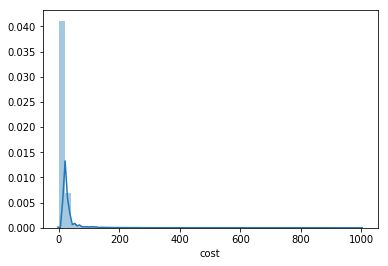

In [71]:
%matplotlib inline
import seaborn as sns
sns.distplot(y_train);

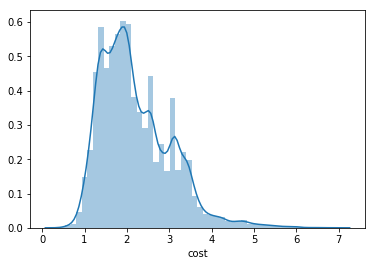

In [74]:
y_train_log = np.log1p(y_train)
sns.distplot(y_train_log);

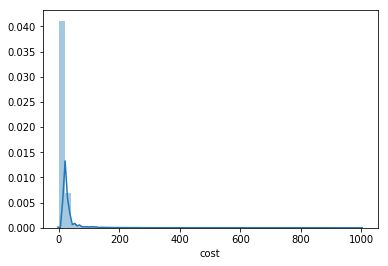

In [75]:
y_train_log_exp = np.expm1(y_train_log)
sns.distplot(y_train_log_exp);

In [76]:
all(np.isclose(y_train_log_exp, y_train))

True

### Refit model with log-transformed target

In [79]:
model.fit(X_train, y_train_log)

y_pred_log = model.predict(X_val)

y_pred = np.expm1(y_pred_log)
rmsle(y_val, y_pred)

0.622925465880199

### RMSLE with original targets = RMSE with log-transformed targets

In [80]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [81]:
y_val_log = np.log1p(y_val)
rmse(y_val_log, y_pred_log)

0.622925465880199

### Select more features

#### [Data Description](https://www.kaggle.com/c/caterpillar-tube-pricing/data)

> **train_set.csv and test_set.csv**  
> This file contains information on price quotes from our suppliers. Prices can be quoted in 2 ways: bracket and non-bracket pricing. Bracket pricing has multiple levels of purchase based on quantity (in other words, the cost is given assuming a purchase of quantity tubes). Non-bracket pricing has a minimum order amount (min_order) for which the price would apply. Each quote is issued with an annual_usage, an estimate of how many tube assemblies will be purchased in a given year.

In [ ]:
#!pip install category_encoders

In [82]:
train.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost
8,TA-00004,S-0066,2013-07-07,0,0,Yes,1,21.972702
9,TA-00004,S-0066,2013-07-07,0,0,Yes,2,12.407983
10,TA-00004,S-0066,2013-07-07,0,0,Yes,5,6.668596
11,TA-00004,S-0066,2013-07-07,0,0,Yes,10,4.754539
12,TA-00004,S-0066,2013-07-07,0,0,Yes,25,3.608331


In [83]:
def wrangle(X):
    X = X.copy()
    
    # Engineer date features
    X['quote_date'] = pd.to_datetime(X['quote_date'], infer_datetime_format=True)
    X['quote_date_year'] = X['quote_date'].dt.year
    X['quote_date_month'] = X['quote_date'].dt.month
    X = X.drop(columns='quote_date')
    
    # Drop tube_assembly_id because our goal is to predict unknown assemblies
    X = X.drop(columns='tube_assembly_id')
    
    return X

train_wrangled = wrangle(train)
val_wrangled = wrangle(val)

In [84]:
features = train_wrangled.columns.drop(target)
print('Features:', features.tolist())

Features: ['supplier', 'annual_usage', 'min_order_quantity', 'bracket_pricing', 'quantity', 'quote_date_year', 'quote_date_month']


In [85]:
X_train = train_wrangled[features]
X_val = val_wrangled[features]

In [86]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train_log)
y_pred_log = pipeline.predict(X_val)
rmse(y_val_log, y_pred_log)

0.3950176959701

In [87]:
y_pred = np.expm1(y_pred_log)
rmsle(y_val, y_pred)

0.3950176959701

#### Feature Importances

In [91]:
pipeline.named_steps['randomforestregressor'].feature_importances_

array([0.10029194, 0.17448178, 0.0453758 , 0.00654028, 0.52551195,
       0.08767022, 0.06012802])

In [92]:
X_train.columns

Index(['supplier', 'annual_usage', 'min_order_quantity', 'bracket_pricing',
       'quantity', 'quote_date_year', 'quote_date_month'],
      dtype='object')

In [93]:
rf = pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)

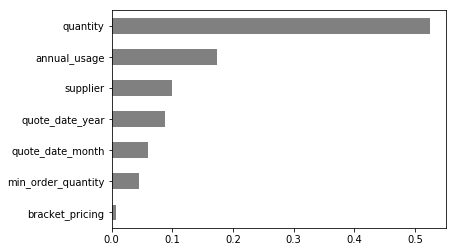

In [95]:
importances.sort_values().plot.barh(color='grey');

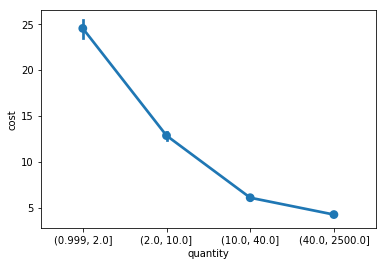

In [98]:
quantity_quartiles = pd.qcut(train_wrangled['quantity'], q=4)
sns.pointplot(x=quantity_quartiles, y=train_wrangled['cost']);

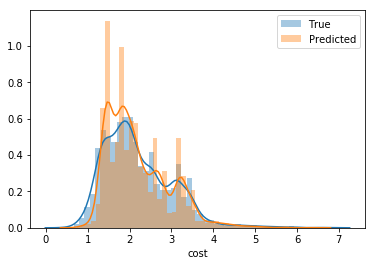

In [99]:
import matplotlib.pyplot as plt
sns.distplot(y_val_log, label='True')
sns.distplot(y_pred_log, label='Predicted')
plt.legend();

## Do feature engineering with relational data

#### [Data Description](https://www.kaggle.com/c/caterpillar-tube-pricing/data)

> The dataset is comprised of a large number of relational tables that describe the physical properties of tube assemblies. You are challenged to combine the characteristics of each tube assembly with supplier pricing dynamics in order to forecast a quote price for each tube.

> **tube.csv**  
> This file contains information on tube assemblies, which are the primary focus of the competition. Tube Assemblies are made of multiple parts. The main piece is the tube which has a specific diameter, wall thickness, length, number of bends and bend radius. Either end of the tube (End A or End X) typically has some form of end connection allowing the tube assembly to attach to other features. Special tooling is typically required for short end straight lengths (end_a_1x, end_a_2x refer to if the end length is less than 1 times or 2 times the tube diameter, respectively). Other components can be permanently attached to a tube such as bosses, brackets or other custom features.

In [100]:
for path in glob('competition_data/*.csv'):
    df = pd.read_csv(path)
    shared_columns = set(df.columns) & set(train.columns)
    if shared_columns:
        print(path, df.shape)
        print(df.columns.tolist(), '\n')

competition_data/bill_of_materials.csv (21198, 17)
['tube_assembly_id', 'component_id_1', 'quantity_1', 'component_id_2', 'quantity_2', 'component_id_3', 'quantity_3', 'component_id_4', 'quantity_4', 'component_id_5', 'quantity_5', 'component_id_6', 'quantity_6', 'component_id_7', 'quantity_7', 'component_id_8', 'quantity_8'] 

competition_data/tube.csv (21198, 16)
['tube_assembly_id', 'material_id', 'diameter', 'wall', 'length', 'num_bends', 'bend_radius', 'end_a_1x', 'end_a_2x', 'end_x_1x', 'end_x_2x', 'end_a', 'end_x', 'num_boss', 'num_bracket', 'other'] 

competition_data/test_set.csv (30235, 8)
['id', 'tube_assembly_id', 'supplier', 'quote_date', 'annual_usage', 'min_order_quantity', 'bracket_pricing', 'quantity'] 

competition_data/specs.csv (21198, 11)
['tube_assembly_id', 'spec1', 'spec2', 'spec3', 'spec4', 'spec5', 'spec6', 'spec7', 'spec8', 'spec9', 'spec10'] 

competition_data/train_set.csv (30213, 8)
['tube_assembly_id', 'supplier', 'quote_date', 'annual_usage', 'min_order_

In [101]:
tube = pd.read_csv('competition_data/tube.csv')

In [102]:
tube.describe()

,diameter,wall,length,num_bends,bend_radius,num_boss,num_bracket,other
count,21198.000000,21198.000000,21198.000000,21198.000000,21198.000000,21198.000000,21198.000000,21198.000000
mean,23.687764,1.578402,100.312844,3.748137,49.350767,0.044485,0.006746,0.022644
std,25.396277,0.745749,70.542771,2.265405,196.468480,0.260737,0.100015,0.199676
min,3.180000,0.710000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.520000,0.890000,48.000000,2.000000,19.050000,0.000000,0.000000,0.000000
50%,15.880000,1.650000,86.000000,3.000000,38.100000,0.000000,0.000000,0.000000
75%,25.400000,1.650000,135.000000,5.000000,50.800000,0.000000,0.000000,0.000000
max,203.200000,7.900000,1333.000000,17.000000,9999.000000,5.000000,5.000000,8.000000


In [103]:
tube.describe(exclude='number')

,tube_assembly_id,material_id,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x
count,21198,20919,21198,21198,21198,21198,21198,21198
unique,21198,19,2,2,2,2,25,27
top,TA-10524,SP-0029,N,N,N,N,EF-003,EF-003
freq,1,11488,20118,18015,20377,18493,11388,10863


In [105]:
def wrangle(X):
    X = X.copy()
    
    # Engineer date features
    X['quote_date'] = pd.to_datetime(X['quote_date'], infer_datetime_format=True)
    X['quote_date_year'] = X['quote_date'].dt.year
    X['quote_date_month'] = X['quote_date'].dt.month
    X = X.drop(columns='quote_date')
    
    # Merge tube data
    tube = pd.read_csv('competition_data/tube.csv')
    X = X.merge(tube, how='left')
    
    # Drop tube_assembly_id because our goal is to predict unknown assemblies
    X = X.drop(columns='tube_assembly_id')
    
    return X


train_wrangled = wrangle(train)
val_wrangled = wrangle(val)

In [106]:
train_wrangled.shape, val_wrangled.shape

((22628, 23), (7585, 23))

In [107]:
train_wrangled.head(10)

,supplier,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,quote_date_year,quote_date_month,material_id,diameter,...,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other
0,S-0066,0,0,Yes,1,21.972702,2013,7,SP-0019,6.35,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
1,S-0066,0,0,Yes,2,12.407983,2013,7,SP-0019,6.35,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
2,S-0066,0,0,Yes,5,6.668596,2013,7,SP-0019,6.35,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
3,S-0066,0,0,Yes,10,4.754539,2013,7,SP-0019,6.35,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
4,S-0066,0,0,Yes,25,3.608331,2013,7,SP-0019,6.35,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
5,S-0066,0,0,Yes,50,3.291176,2013,7,SP-0019,6.35,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
6,S-0066,0,0,Yes,100,3.149291,2013,7,SP-0019,6.35,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
7,S-0066,0,0,Yes,250,3.065829,2013,7,SP-0019,6.35,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
8,S-0066,0,0,Yes,1,28.374220,2013,9,SP-0029,19.05,...,50.80,N,N,N,N,EF-003,EF-003,0,0,0
9,S-0066,0,0,Yes,2,16.514303,2013,9,SP-0029,19.05,...,50.80,N,N,N,N,EF-003,EF-003,0,0,0


In [108]:
X_train = train_wrangled.drop(columns=target)
X_val = val_wrangled.drop(columns=target)

In [109]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train_log)

Pipeline(memory=None,
     steps=[('ordinalencoder', OrdinalEncoder(cols=['supplier', 'bracket_pricing', 'material_id', 'end_a_1x', 'end_a_2x', 'end_x_1x', 'end_x_2x', 'end_a', 'end_x'],
        drop_invariant=False, handle_missing='value',
        handle_unknown='value',
        mapping=[{'col': 'supplier', 'mapping': S-0066...timators=100, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [110]:
y_pred_log = pipeline.predict(X_val)
rmse(y_val_log, y_pred_log)

0.3067473950776893

In [111]:
test_wrangled = wrangle(test)
X_test = test_wrangled.drop(columns='id')
all(X_test.columns == X_train.columns)

True

In [112]:
y_pred_log = pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission['cost'] = y_pred
submission.to_csv('submission-01.csv', index=False)

# Assignment
- Start a clean notebook.
- Get the [Caterpillar data from Kaggle](https://www.kaggle.com/c/caterpillar-tube-pricing/data).
- Do train/validate/test split.
- Select features from `train_set.csv`, `tube.csv`, and at least one more file.
- Fit a model.
- Get your validation RMSLE (or RMSE with log-transformed targets).
- [Submit](https://www.kaggle.com/c/caterpillar-tube-pricing/submit) your predictions to the Kaggle competition.
- Commit your notebook to your fork of the GitHub repo.

## Stretch Goals
- Improve your scores on Kaggle.
- Make visualizations and share on Slack.
- Look at [Kaggle Kernels](https://www.kaggle.com/c/caterpillar-tube-pricing/kernels) for ideas about feature engineering and visualization.

Read [Better Explained](https://betterexplained.com/) Exponents & Logs series:

1. [An Intuitive Guide To Exponential Functions & e](https://betterexplained.com/articles/an-intuitive-guide-to-exponential-functions-e/)
2. [Demystifying the Natural Logarithm (ln)](https://betterexplained.com/articles/demystifying-the-natural-logarithm-ln/)
3. [A Visual Guide to Simple, Compound and Continuous Interest Rates](https://betterexplained.com/articles/a-visual-guide-to-simple-compound-and-continuous-interest-rates/)
4. [Common Definitions of e (Colorized)](https://betterexplained.com/articles/definitions-of-e-colorized/)
5. [Understanding Exponents (Why does 0^0 = 1?)](https://betterexplained.com/articles/understanding-exponents-why-does-00-1/)
6. [Using Logarithms in the Real World](https://betterexplained.com/articles/using-logs-in-the-real-world/)
7. [How To Think With Exponents And Logarithms](https://betterexplained.com/articles/think-with-exponents/)
8. [Understanding Discrete vs. Continuous Growth](https://betterexplained.com/articles/understanding-discrete-vs-continuous-growth/)
9. [What does an exponent really mean?](https://betterexplained.com/articles/what-does-an-exponent-mean/)
10. [Q: Why is e special? (2.718..., not 2, 3.7 or another number?)](https://betterexplained.com/articles/q-why-is-e-special-2-718-not-other-number/)